# Overview

As a data scientist, I want to get the information about the types of workloads, images , containers, shapes, etc and their inter-relationships from the insight operator data-set. For this purpose, I would like to perform, EDA on the workload data from 4.8+ clusters collected from the [Insight Operator Archive](https://github.com/openshift/insights-operator/blob/master/docs/insights-archive-sample/config/workload_info.json).

Exploratory Data Analysis is the initial analysis that we perform on the data to understand the data. It is important because before we create models or perform operations on the data, we should know what the data is all about, what all features it consists of, how these features are related to each other, etc. 

# Containers and Images 

Containers, images and image streams are important concepts to understand when we set out to create and manage containerized software. An image holds a set of software that is ready to run, while a container is a running instance of the container image. An image stream provides a way of storing different versions of the same basic image. Those different versions are represented by different tags on the same image name. 

# Data Collection

Here we import the two kinds of dataset from the DH-PLAYPEN bucket.

Firstly, installing some useful packages used in the analysis.

In [1]:
#!pip install --upgrade pip
#!pip install python-dotenv
#!pip install dataprep

In [2]:
import io
import boto3
import pandas as pd
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt

from dataprep.eda import plot

from dotenv import load_dotenv, find_dotenv

In [3]:
%matplotlib inline
load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

In [3]:
# CEPH Bucket variables
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

# s3 resource to communicate with storage
s3 = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

# access the parquet file as an s3 object

obj1 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/date=2021-05-12/2021-05-12.parquet"
)
obj2 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/date=2021-05-12/2021-05-12.parquet"
)
obj3 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/dataframe_image_id.parquet"
)
obj4 = s3.Object("DH-PLAYPEN", "ccx/fingerprinting/containers/df_cont_image_id.parquet")
# download the file into the buffer
buffer1 = io.BytesIO()
obj1.download_fileobj(buffer1)
buffer2 = io.BytesIO()
obj2.download_fileobj(buffer2)
buffer3 = io.BytesIO()
obj3.download_fileobj(buffer3)
buffer4 = io.BytesIO()
obj4.download_fileobj(buffer4)

# read the buffer and create the dataframe
image_layers_df = pd.read_parquet(buffer1)
image_id_map = pd.read_parquet(buffer3)
containers_df = pd.read_parquet(buffer2)
cont_id_map = pd.read_parquet(buffer4)

We now have the four sets of dataframe,

- Image layer dataset (_*image_layers_df*_)
- Product name mapping for sha's of image_id from image layer dataset (_*image_id_mapping*_)
- Containers dataset (_*containers_df*_)
- Product name mapping for sha's of the image_id from container dataset (_*cont_imageid_map*_)

**Image layer Dataset**

In [4]:
image_layers_df.head()

cluster_id  \
0  00003d61-9db1-4757-9cd1-84df271daeb9   
1  00003d61-9db1-4757-9cd1-84df271daeb9   
2  00003d61-9db1-4757-9cd1-84df271daeb9   
3  00003d61-9db1-4757-9cd1-84df271daeb9   
4  00003d61-9db1-4757-9cd1-84df271daeb9   

                                            image_id  \
0  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
1  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
2  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
3  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
4  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   

                                      layer_image_id  layer_image_level  \
0  sha256:9ebb302e1fb002fb643091710dac46f8258781d...                  0   
1  sha256:a74396a32e85c2feeedf76052ed3297859810c8...                  1   
2  sha256:7db62383a7470afbacfc0fab55d5a182e3c5fa2...                  2   
3  sha256:f24250419f728db23957454976d6d38b679a349...                  3   
4  sha256:267f7bb0f5dcf1b83f8ce89831d05f3a44a3abe...                  4   

  first_command     first_arg  \
0  icTsn2s_EIax  2v1NneeWoS_9   
1  icTsn2s_EIax  2v1NneeWoS_9   
2  icTsn2s_EIax  2v1NneeWoS_9   
3  icTsn2s_EIax  2v1NneeWoS_9   
4  icTsn2s_EIax  2v1NneeWoS_9   

                                        archive_path  
0  archives/compressed/00/00003d61-9db1-4757-9cd1...  
1  archives/compressed/00/00003d61-9db1-4757-9cd1...  
2  archives/compressed/00/00003d61-9db1-4757-9cd1...  
3  archives/compressed/00/00003d61-9db1-4757-9cd1...  
4  archives/compressed/00/00003d61-9db1-4757-9cd1...

In [5]:
image_id_map = image_id_map.reset_index()
image_id_map.head()

image_id License architecture  \
0  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...  GPLv2+       x86_64   
1  sha256:3574d6c1fcc46e1ebd41b7b887b92035ea18213...  GPLv2+       x86_64   
2  sha256:c588b4653ef037b1300f9692b986cbeac5dfe5e...  GPLv2+       x86_64   
3  sha256:7b879d0179b96fe682a186af60836e4091f1fd3...  GPLv2+       x86_64   
4  sha256:85a79d95924e4a76b1a6ccd974b2c99df349f07...  GPLv2+       x86_64   

                   build-date                       com.redhat.build-host  \
0  2021-04-30T00:31:42.349887  cpt-1004.osbs.prod.upshift.rdu2.redhat.com   
1  2021-04-30T00:22:29.539443  cpt-1008.osbs.prod.upshift.rdu2.redhat.com   
2  2021-05-04T21:53:04.228477  cpt-1005.osbs.prod.upshift.rdu2.redhat.com   
3  2021-04-29T23:09:36.775464  cpt-1008.osbs.prod.upshift.rdu2.redhat.com   
4  2021-05-08T07:13:14.635470  cpt-1007.osbs.prod.upshift.rdu2.redhat.com   

                            com.redhat.component  \
0                    ose-cli-artifacts-container   
1             openshift-enterprise-cli-container   
2  golang-github-openshift-oauth-proxy-container   
3  golang-github-openshift-oauth-proxy-container   
4  golang-github-openshift-oauth-proxy-container   

            com.redhat.license_terms  \
0  https://www.redhat.com/agreements   
1  https://www.redhat.com/agreements   
2  https://www.redhat.com/agreements   
3  https://www.redhat.com/agreements   
4  https://www.redhat.com/agreements   

                                         description distribution-scope  \
0  OpenShift is a platform for developing, buildi...             public   
1  OpenShift is a platform for developing, buildi...             public   
2                             OpenShift OAuth Proxy.             public   
3                             OpenShift OAuth Proxy.             public   
4                             OpenShift OAuth Proxy.             public   

                                  io.k8s.description  ...  \
0  OpenShift is a platform for developing, buildi...  ...   
1  OpenShift is a platform for developing, buildi...  ...   
2                             OpenShift OAuth Proxy.  ...   
3                             OpenShift OAuth Proxy.  ...   
4                             OpenShift OAuth Proxy.  ...   

  authoritative-source-url io.fabric8.s2i.version.jolokia org.concrt.version  \
0                     None                           None               None   
1                     None                           None               None   
2                     None                           None               None   
3                     None                           None               None   
4                     None                           None               None   

  org.jboss.product org.jboss.product.amq.version  \
0              None                          None   
1              None                          None   
2              None                          None   
3              None                          None   
4              None                          None   

  org.jboss.product.openjdk.version org.jboss.product.version  \
0                              None                      None   
1                              None                      None   
2                              None                      None   
3                              None                      None   
4                              None                      None   

  com.redhat.deployments-dir com.redhat.dev-mode io.jenkins.version  
0                       None                None               None  
1                       None                None               None  
2                       None                None               None  
3                       None                None               None  
4                       None                None               None  

[5 rows x 41 columns]

In [6]:
containers_df.head()

cluster_id     namespace  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
1  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
2  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
3  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
4  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   

                                               shape  shape_instances  \
0  sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...                1   
1  sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...                1   
2  sha256:542d007d13008cc1be2dbf03601b954c4452947...                1   
3  sha256:542d007d13008cc1be2dbf03601b954c4452947...                1   
4  sha256:542d007d13008cc1be2dbf03601b954c4452947...                1   

                                            image_id first_command  \
0  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   
1  sha256:edb9aaacf421c6dc45b20324e8699cec02f26bf...  n9CdwzVF-cwZ   
2  sha256:a693c315b775c693dc49c19b7f217762676bc28...  b51B0EZ1bw3c   
3  sha256:a693c315b775c693dc49c19b7f217762676bc28...  Cl6kTzfbYztA   
4  sha256:d9c64d038f16e04c52142bc9e7dfa0645ce7e34...  Cl6kTzfbYztA   

      first_arg  init_container  \
0  47DEQpj8HBSa           False   
1  RNOaw_AuQeIY           False   
2  ua-xlwwsvdYd           False   
3          None            True   
4          None            True   

                                        archive_path  
0  archives/compressed/00/00003d61-9db1-4757-9cd1...  
1  archives/compressed/00/00003d61-9db1-4757-9cd1...  
2  archives/compressed/00/00003d61-9db1-4757-9cd1...  
3  archives/compressed/00/00003d61-9db1-4757-9cd1...  
4  archives/compressed/00/00003d61-9db1-4757-9cd1...

In [7]:
cont_id_map = cont_id_map.reset_index()
cont_id_map.head()

image_id  License architecture  \
0  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...  ASL 2.0       x86_64   
1  sha256:edb9aaacf421c6dc45b20324e8699cec02f26bf...   GPLv2+       x86_64   
2  sha256:a693c315b775c693dc49c19b7f217762676bc28...   GPLv2+       x86_64   
3  sha256:d9c64d038f16e04c52142bc9e7dfa0645ce7e34...   GPLv2+       x86_64   
4  sha256:af32a5e5489c79461bf64c6e55bd34e1c1c1bd9...   GPLv2+       x86_64   

                   build-date                       com.redhat.build-host  \
0  2021-05-04T21:54:58.392948  cpt-1007.osbs.prod.upshift.rdu2.redhat.com   
1  2021-05-04T22:05:48.018566  cpt-1006.osbs.prod.upshift.rdu2.redhat.com   
2  2021-05-04T21:53:09.591552  cpt-1006.osbs.prod.upshift.rdu2.redhat.com   
3  2021-05-04T22:19:44.056847  cpt-1003.osbs.prod.upshift.rdu2.redhat.com   
4  2021-05-04T22:18:44.217005  cpt-1004.osbs.prod.upshift.rdu2.redhat.com   

                        com.redhat.component  \
0                  kube-rbac-proxy-container   
1  ose-multus-admission-controller-container   
2                       multus-cni-container   
3            ose-egress-router-cni-container   
4  ose-containernetworking-plugins-container   

            com.redhat.license_terms  \
0  https://www.redhat.com/agreements   
1  https://www.redhat.com/agreements   
2  https://www.redhat.com/agreements   
3  https://www.redhat.com/agreements   
4  https://www.redhat.com/agreements   

                                         description distribution-scope  \
0  This is a proxy, that can perform Kubernetes R...             public   
1  This is a component of OpenShift Container Pla...             public   
2  This is a component of OpenShift Container Pla...             public   
3                       CNI Plugin for Egress Router             public   
4  This is a component of OpenShift Container Pla...             public   

                                  io.k8s.description  ...  \
0  This is a proxy, that can perform Kubernetes R...  ...   
1  This is a component of OpenShift Container Pla...  ...   
2  This is a component of OpenShift Container Pla...  ...   
3                       CNI Plugin for Egress Router  ...   
4  This is a component of OpenShift Container Pla...  ...   

  com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.version  \
0                                               None              
1                                               None              
2                                               None              
3                                               None              
4                                               None              

  com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.commitid  \
0                                               None                         
1                                               None                         
2                                               None                         
3                                               None                         
4                                               None                         

  com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.job  \
0                                               None                    
1                                               None                    
2                                               None                    
3                                               None                    
4                                               None                    

  com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.license  \
0                                               None                        
1                                               None                        
2                                               None                        
3                                               None                        
4                                               None                

Using the mapping techniques from the [issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/14), we were able to map most (not all) of the image_id from the image layers dataset and containers datsets. In the next steps, we try to merge the two datset with respect to the image_id. The '_product name_' and '_summary_' of the image_id that were not mapped were left blank.

In the next section, we take the information about the _product name_ and _summary_ from the mapped dataset.

In [8]:
image_id_mapping = image_id_map[["image_id", "name", "summary"]]
cont_imageid_map = cont_id_map[["image_id", "name", "summary"]]

# Merging the datasets with respect to the image_id 

**Merged dataframe for image layers dataset**

In [9]:
df_image = pd.merge(image_layers_df, image_id_mapping, how="outer")
df_image.head()

cluster_id  \
0  00003d61-9db1-4757-9cd1-84df271daeb9   
1  00003d61-9db1-4757-9cd1-84df271daeb9   
2  00003d61-9db1-4757-9cd1-84df271daeb9   
3  00003d61-9db1-4757-9cd1-84df271daeb9   
4  00003d61-9db1-4757-9cd1-84df271daeb9   

                                            image_id  \
0  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
1  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
2  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
3  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
4  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   

                                      layer_image_id  layer_image_level  \
0  sha256:9ebb302e1fb002fb643091710dac46f8258781d...                  0   
1  sha256:a74396a32e85c2feeedf76052ed3297859810c8...                  1   
2  sha256:7db62383a7470afbacfc0fab55d5a182e3c5fa2...                  2   
3  sha256:f24250419f728db23957454976d6d38b679a349...                  3   
4  sha256:267f7bb0f5dcf1b83f8ce89831d05f3a44a3abe...                  4   

  first_command     first_arg  \
0  icTsn2s_EIax  2v1NneeWoS_9   
1  icTsn2s_EIax  2v1NneeWoS_9   
2  icTsn2s_EIax  2v1NneeWoS_9   
3  icTsn2s_EIax  2v1NneeWoS_9   
4  icTsn2s_EIax  2v1NneeWoS_9   

                                        archive_path  \
0  archives/compressed/00/00003d61-9db1-4757-9cd1...   
1  archives/compressed/00/00003d61-9db1-4757-9cd1...   
2  archives/compressed/00/00003d61-9db1-4757-9cd1...   
3  archives/compressed/00/00003d61-9db1-4757-9cd1...   
4  archives/compressed/00/00003d61-9db1-4757-9cd1...   

                          name  \
0  openshift/ose-cli-artifacts   
1  openshift/ose-cli-artifacts   
2  openshift/ose-cli-artifacts   
3  openshift/ose-cli-artifacts   
4  openshift/ose-cli-artifacts   

                                             summary  
0  Provides the latest release of Red Hat Univers...  
1  Provides the latest release of Red Hat Univers...  
2  Provides the latest release of Red Hat Univers...  
3  Provides the latest release of Red Hat Univers...  
4  Provides the latest release of Red Hat Univers...

**Merged dataframe for containers dataset**

In [10]:
df_cont = pd.merge(containers_df, cont_imageid_map, how="outer")
df_cont.head()

cluster_id     namespace  \
0  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
1  00003d61-9db1-4757-9cd1-84df271daeb9  0LiT6ZNtbpYL   
2  00003d61-9db1-4757-9cd1-84df271daeb9  EOB8Fqt74gVH   
3  00003d61-9db1-4757-9cd1-84df271daeb9  ICyEPw5KVYuy   
4  00003d61-9db1-4757-9cd1-84df271daeb9  N3z7Gdl4s2xN   

                                               shape  shape_instances  \
0  sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...                1   
1  sha256:1e2788d7ec32815d3a0c2ded714ea4f57fc1c05...                1   
2  sha256:02d566833422864543388795bc184bff1a93290...                1   
3  sha256:b41ba85921418eb16c2e30007a13730441841de...                1   
4  sha256:12df16c0ad0807f5feaaa24563bc10a76895b54...                1   

                                            image_id first_command  \
0  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   
1  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   
2  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   
3  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   
4  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...          None   

      first_arg  init_container  \
0  47DEQpj8HBSa           False   
1  47DEQpj8HBSa           False   
2  aV86_fLS8Aye           False   
3  47DEQpj8HBSa           False   
4  47DEQpj8HBSa           False   

                                        archive_path  \
0  archives/compressed/00/00003d61-9db1-4757-9cd1...   
1  archives/compressed/00/00003d61-9db1-4757-9cd1...   
2  archives/compressed/00/00003d61-9db1-4757-9cd1...   
3  archives/compressed/00/00003d61-9db1-4757-9cd1...   
4  archives/compressed/00/00003d61-9db1-4757-9cd1...   

                            name summary  
0  openshift/ose-kube-rbac-proxy          
1  openshift/ose-kube-rbac-proxy          
2  openshift/ose-kube-rbac-proxy          
3  openshift/ose-kube-rbac-proxy          
4  openshift/ose-kube-rbac-proxy

# **Inspecting the Container Dataset**

We inspect the container data-set by employing a python package called dataprep. _Dataprepare_ is an initiative of [SFU Data Science Research Group](https://data.cs.sfu.ca/index.html) to speed up Data Science. It attempts to simplify the entire EDA process with very minimal lines of code. Using this package, we will get the detailed report of our dataset. 

Checking different features in the dataset,

In [11]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456825 entries, 0 to 456824
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   cluster_id       456825 non-null  object
 1   namespace        456825 non-null  object
 2   shape            456825 non-null  object
 3   shape_instances  456825 non-null  int64 
 4   image_id         456825 non-null  object
 5   first_command    267122 non-null  object
 6   first_arg        328832 non-null  object
 7   init_container   456825 non-null  bool  
 8   archive_path     456825 non-null  object
 9   name             269715 non-null  object
 10  summary          269710 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 38.8+ MB


Creating a report using the dataprep package and saving it as a html file.

  0%|          | 0/7 [00:00<?, ?it/s]

100%|##########| 3/3 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]


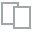
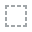
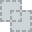
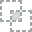
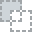
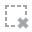
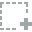
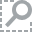
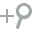
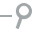
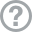
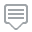
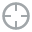
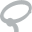
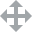
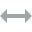
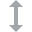
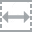
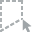
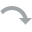
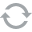
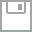
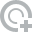
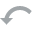
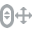
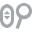
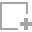
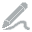
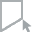
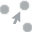
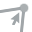
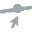

In [12]:
plot(df_cont)

The overview of the dataset statistics shows that the dataset containes 456825 rows with 11 variables. The dataset does have missing cells from *first_arg*, *first_command*, *name*, and *summary* columns. The missing cells for *name* and *summary* are because of the fact that we were able to map about 45% of the image_id from the image layer dataset using the pyxis mapping technique.

Furthermore, the plot gives us the distribution of a particular variable in the dataset. 

# Inspecting the Image layer dataset

We inspect the image layer dataset using the previous applied method, i.e, using the _*dataprep*_ package. 

The different features in the dataset are listed below.

In [13]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47368 entries, 0 to 47367
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   cluster_id         47368 non-null  object
 1   image_id           47368 non-null  object
 2   layer_image_id     47368 non-null  object
 3   layer_image_level  47368 non-null  int64 
 4   first_command      34038 non-null  object
 5   first_arg          41209 non-null  object
 6   archive_path       47368 non-null  object
 7   name               27524 non-null  object
 8   summary            27524 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.6+ MB


  0%|          | 0/283 [00:00<?, ?it/s]


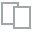
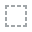
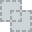
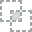
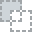
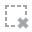
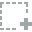
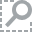
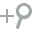
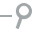
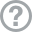
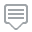
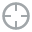
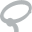
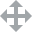
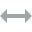
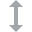
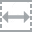
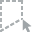
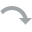
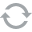
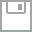
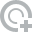
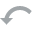
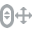
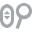
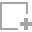
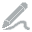
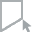
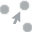
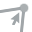
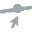

In [14]:
plot(df_image)

The initial inspection with the help of dataprep package does gives us some idea about how different variables are distributed in the dataset. It gives an information about the most occured variable in the dataset. It also gives an information about the missing values. Similar to the container dataset, the missing values for the _name_ and _summary_ columns, are as a result of mapping about 45% of the image_id. 

---

# Some FAQs

## How many unique product name are there in image layer dataset and container dataset?

For the image layer dataset, the list of unique product name are listed below.

In [15]:
print(list(df_image.name.unique()))

print("\n")

print(
    "The number of unique product name extracted for image layer dataset is :",
    df_image.name.nunique(),
)

['openshift/ose-cli-artifacts', 'openshift/ose-cli', 'openshift/ose-oauth-proxy', nan, 'ubi8/ruby-27', 'rhel8/postgresql-12', 'openshift/ose-tools', 'rhel8/mysql-80', 'openshift/ose-must-gather', 'rhscl/postgresql-10-rhel7', 'rhel8/redis-5', 'rhel8/postgresql-10', 'rhscl/mongodb-36-rhel7', 'openshift/ose-grafana', 'rhel8/httpd-24', 'openshift/ose-tests', 'jboss-amq-6/amq63-openshift', '3scale-amp2/system-rhel7', '3scale-amp2/apicast-gateway-rhel8', 'rhscl/mysql-57-rhel7', 'rhscl/redis-32-rhel7', '3scale-amp2/backend-rhel7', '3scale-amp2/memcached-rhel7', '3scale-amp2/zync-rhel7', 'ubi8/dotnet-50', 'openshift/ose-jenkins']


The number of unique product name extracted for image layer dataset is : 25


For the container dataset, the list of unique product names are list below:

In [16]:
print(list(df_cont.name.unique()))

print("\n")

print(
    "The number of unique product name extracted for image layer dataset is :",
    df_cont.name.nunique(),
)

['openshift/ose-kube-rbac-proxy', 'openshift/ose-multus-admission-controller', 'openshift/ose-multus-cni', 'openshift/ose-egress-router-cni', 'openshift/ose-container-networking-plugins', 'openshift/ose-multus-route-override-cni', 'openshift/ose-multus-whereabouts-ipam-cni', 'openshift/ose-network-metrics-daemon', 'openshift/ose-cluster-config-operator', nan, 'openshift/ose-operator-marketplace', 'openshift/ose-etcd', 'openshift/ose-hyperkube', 'openshift/ose-cluster-kube-scheduler-operator', 'openshift/ose-cluster-storage-operator', 'openshift/ose-csi-snapshot-controller', 'openshift/ose-cluster-csi-snapshot-controller-operator', 'openshift/ose-csi-snapshot-validation-webhook', 'openshift/ose-oauth-server', 'openshift/ose-kube-storage-version-migrator', 'openshift/ose-cluster-policy-controller', 'openshift/ose-cluster-kube-controller-manager-operator', 'openshift/ose-service-ca-operator', 'openshift/ose-operator-lifecycle-manager', 'openshift/ose-cloud-credential-operator', 'openshift

## **Are there any images that occur together in a cluster?**

To address this question, we try to find the correlation between different image sha's and the cluster_id's see if there are any images that occur together. We make use of the crosstab function, which builds a cross tabulation table that can show the frequency with which certain groups of data appears.

**Finding the cross tabulation for differnt sha's of image_id with different cluster_id's**

<AxesSubplot:xlabel='cluster_id', ylabel='image_id'>

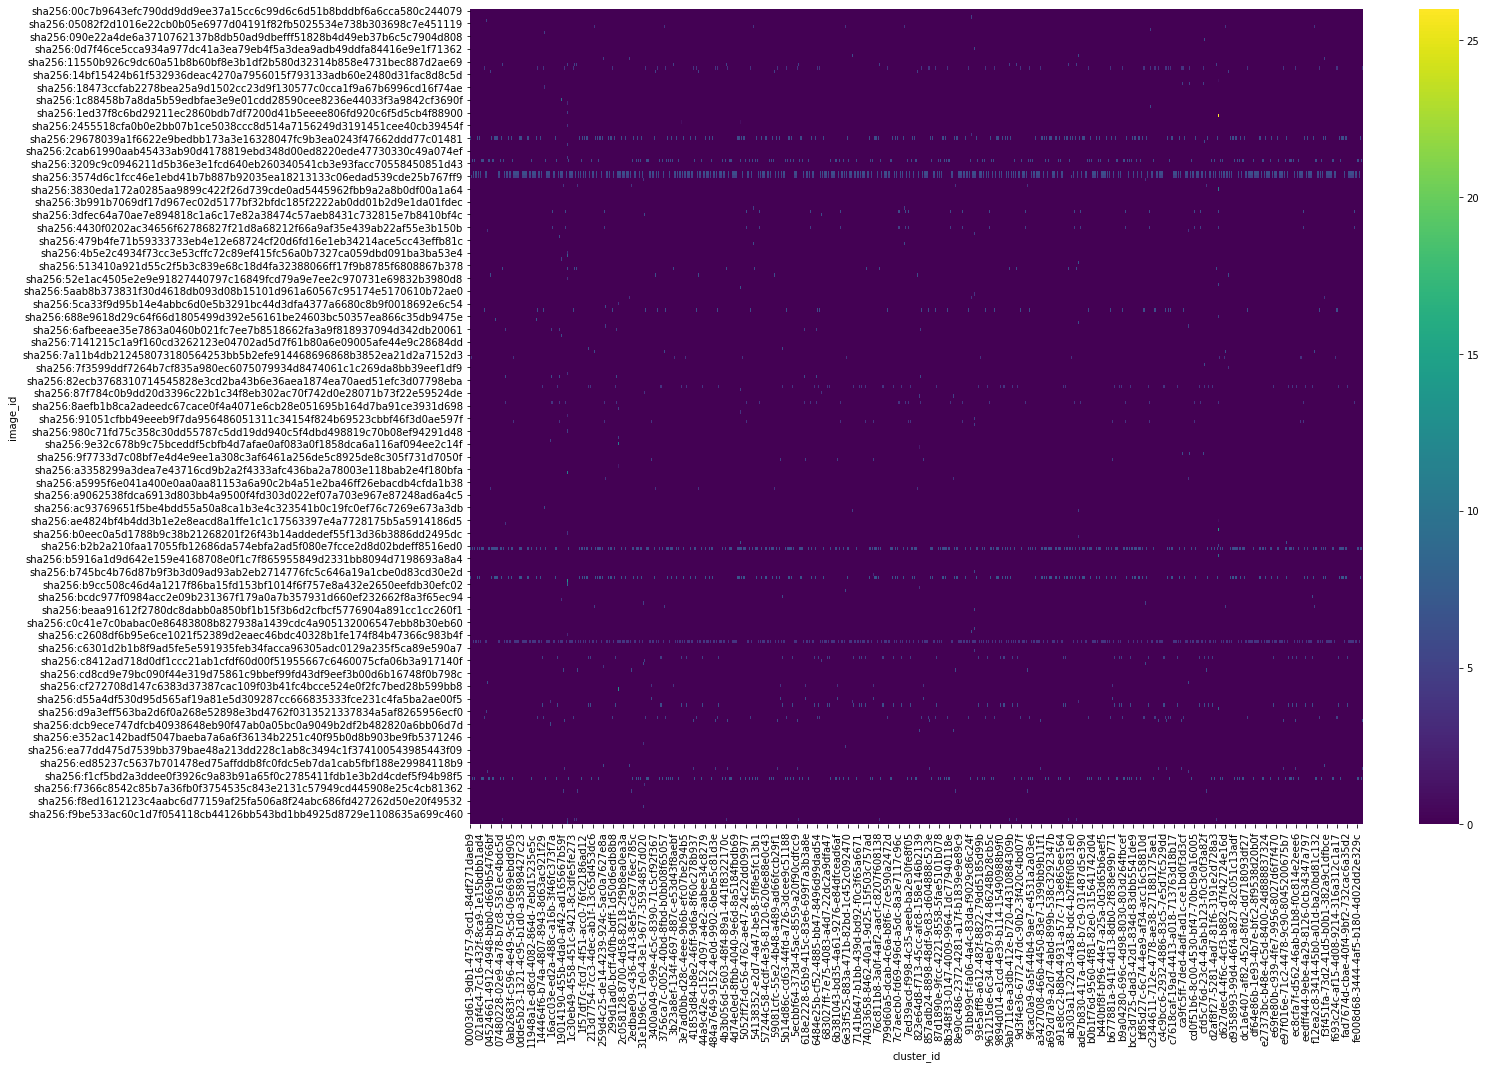

In [17]:
d1 = df_image["image_id"]
d2 = df_image["cluster_id"]

crosstab = pd.crosstab(d1, d2)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstab, cmap="viridis", annot=False)

From the above heat map, we can qualitatively see that, there are some group of image_id's occuring together in a clusters. Next, we will replace image_id with corresponding product name and see if there are any products that occur together in a cluster.

<AxesSubplot:xlabel='cluster_id', ylabel='name'>

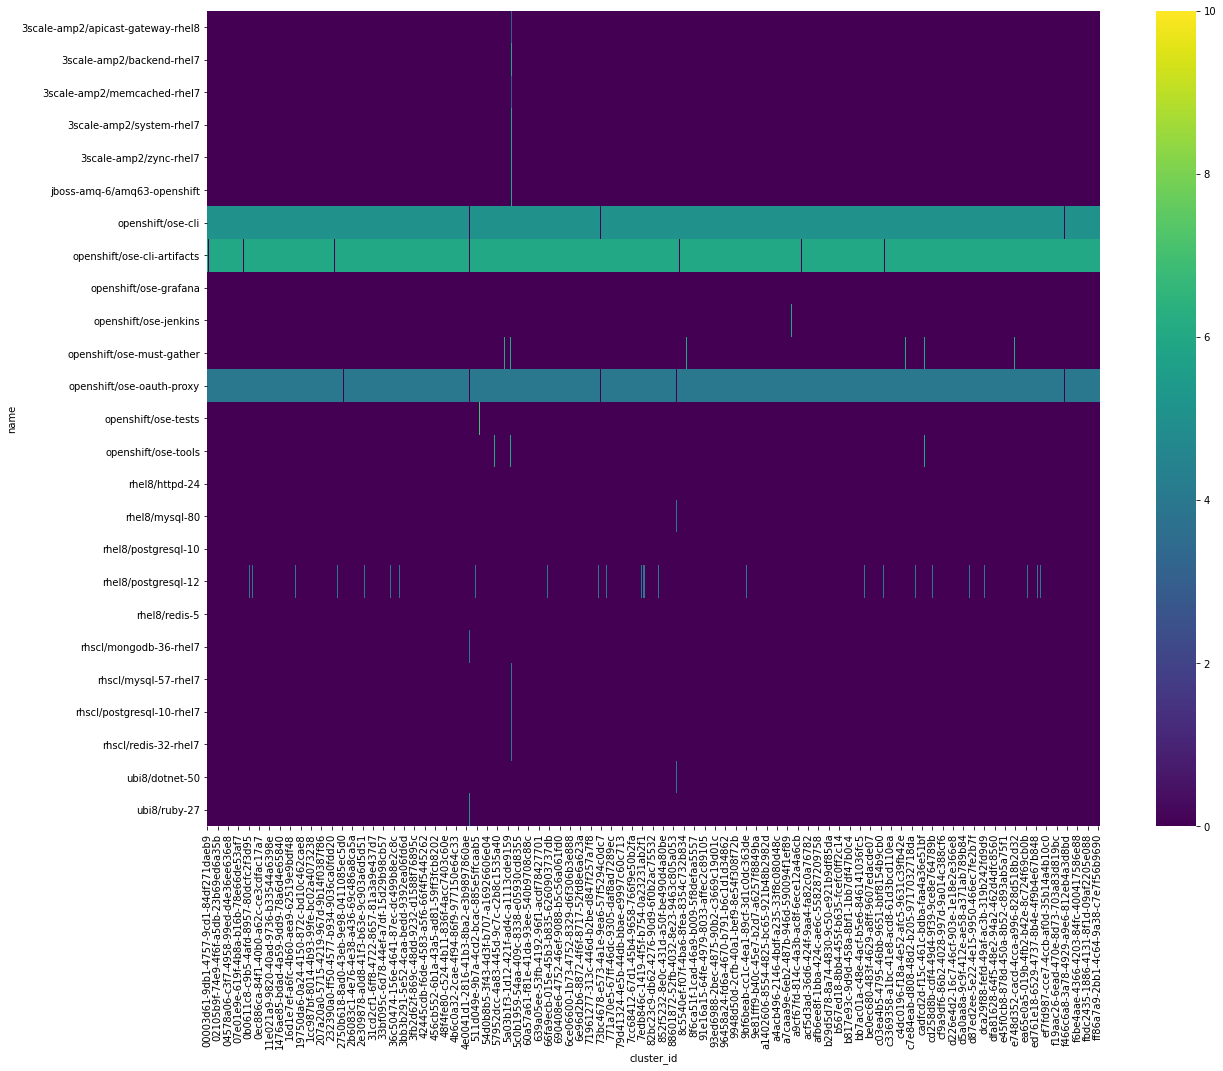

In [18]:
d3 = df_image["name"]
d4 = df_image["cluster_id"]

crosstab = pd.crosstab(d3, d4)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstab, cmap="viridis", annot=False)

The heat map shows more clearer view of the distribution of products across different clusters. We observe that product name such as, _**openshift/ose-cli-artifacts**_, _**openshift/ose-cli**_, _**openshift/ose-oauth-proxy**_ are present in alomost all clusters. If we list out the most populated product name, we have,

In [19]:
s0 = df_image.groupby("name")["cluster_id"].nunique()
s0 = s0.reset_index().sort_values(by="cluster_id", ascending=False)
s0.head(20)

name  cluster_id
6                   openshift/ose-cli        1805
11          openshift/ose-oauth-proxy        1801
7         openshift/ose-cli-artifacts        1799
17                rhel8/postgresql-12          50
10          openshift/ose-must-gather          13
13                openshift/ose-tools          13
19             rhscl/mongodb-36-rhel7           3
15                     rhel8/mysql-80           3
24                       ubi8/ruby-27           2
21          rhscl/postgresql-10-rhel7           2
9               openshift/ose-jenkins           2
14                     rhel8/httpd-24           2
23                     ubi8/dotnet-50           1
22               rhscl/redis-32-rhel7           1
20               rhscl/mysql-57-rhel7           1
18                      rhel8/redis-5           1
0   3scale-amp2/apicast-gateway-rhel8           1
16                rhel8/postgresql-10           1
1           3scale-amp2/backend-rhel7           1
8               openshift/ose-grafana           1

If we plot the product name with corresponding number of cluster_id it is present in. We have,

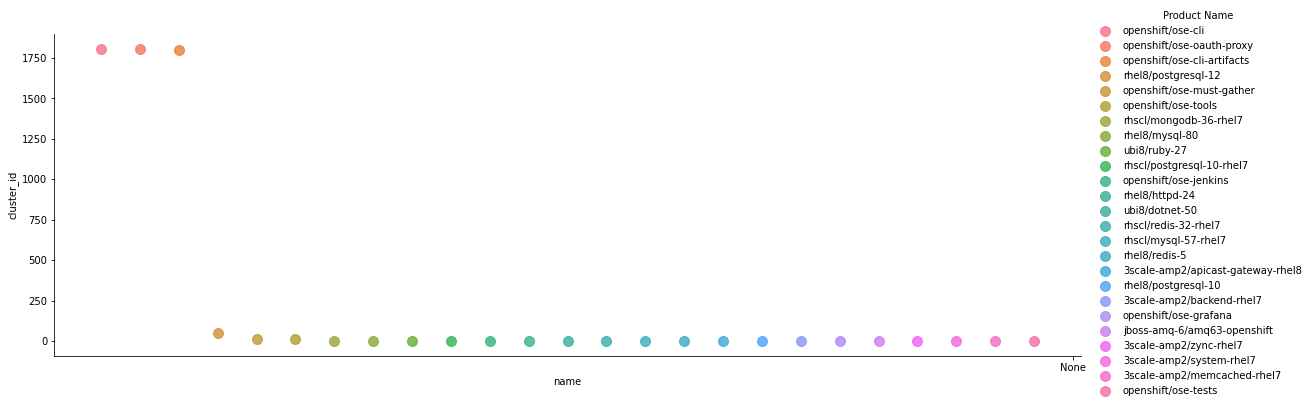

In [20]:
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=s0,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 3.3,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

Performing the similar actions for container dataset image id. We first see the distribution of image_id in different cluster_id.

<AxesSubplot:xlabel='cluster_id', ylabel='image_id'>

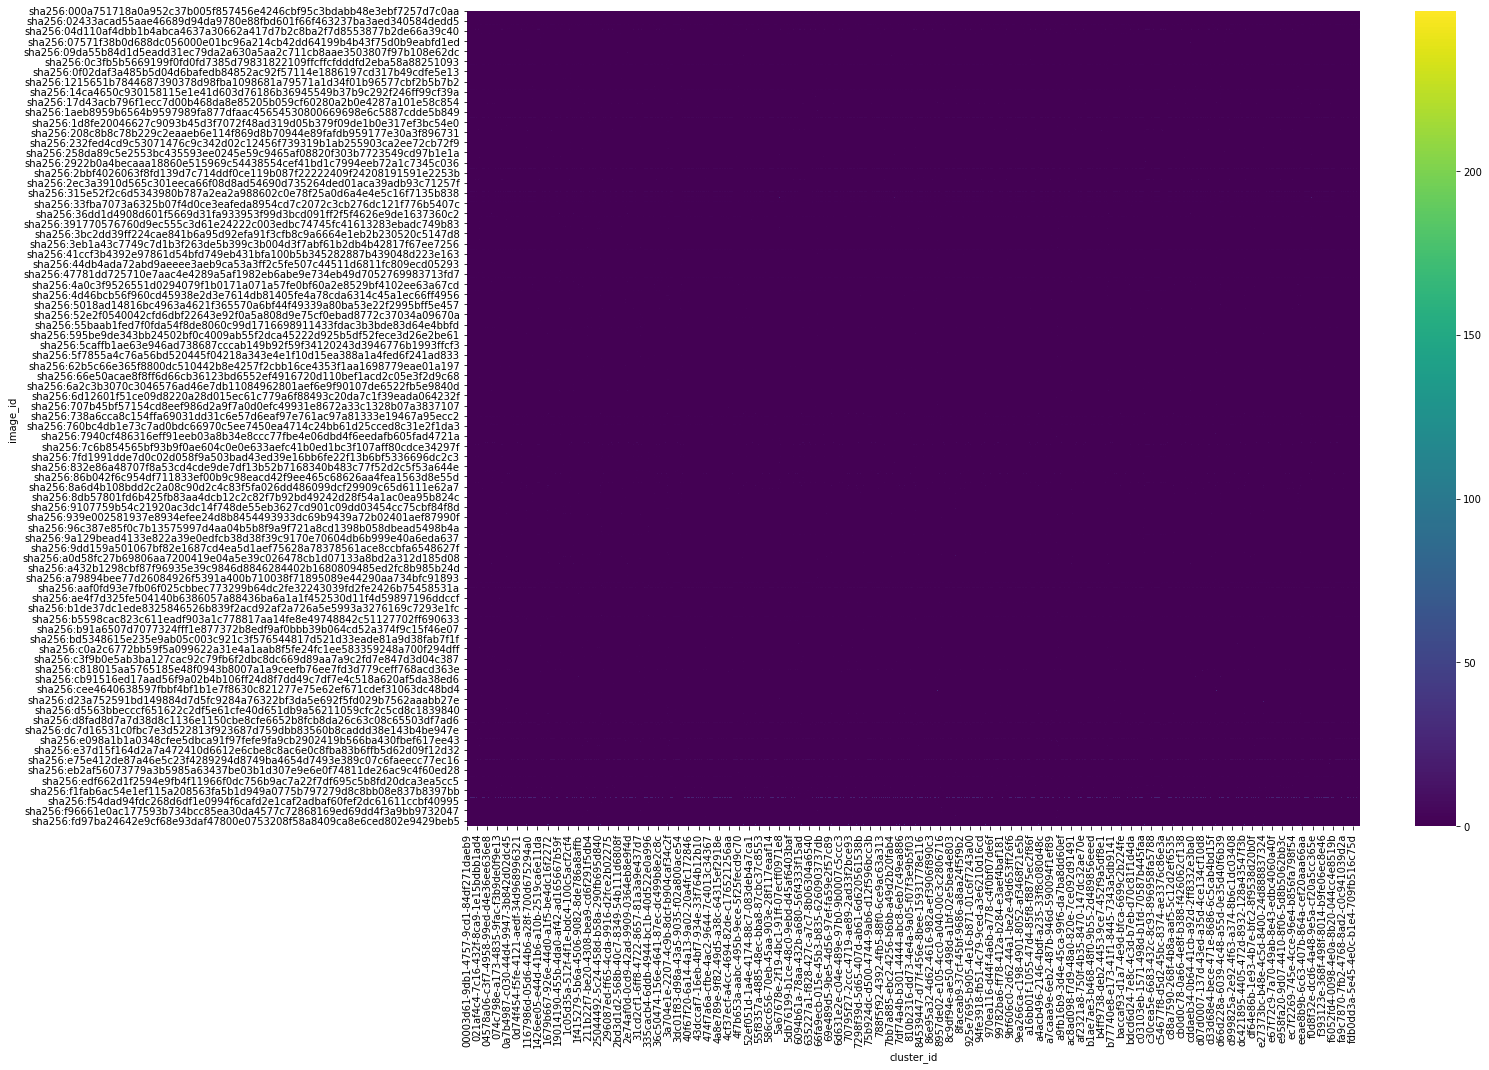

In [21]:
d5 = df_cont["image_id"]
d6 = df_cont["cluster_id"]

crosstab = pd.crosstab(d5, d6)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstab, cmap="viridis", annot=False)

The trend in not the same as that of image layer dataset. We do not see qualitatively, any group of image_id dominating the heatmap. Next, checking the distribution of product name for different cluster id.

<AxesSubplot:xlabel='cluster_id', ylabel='name'>

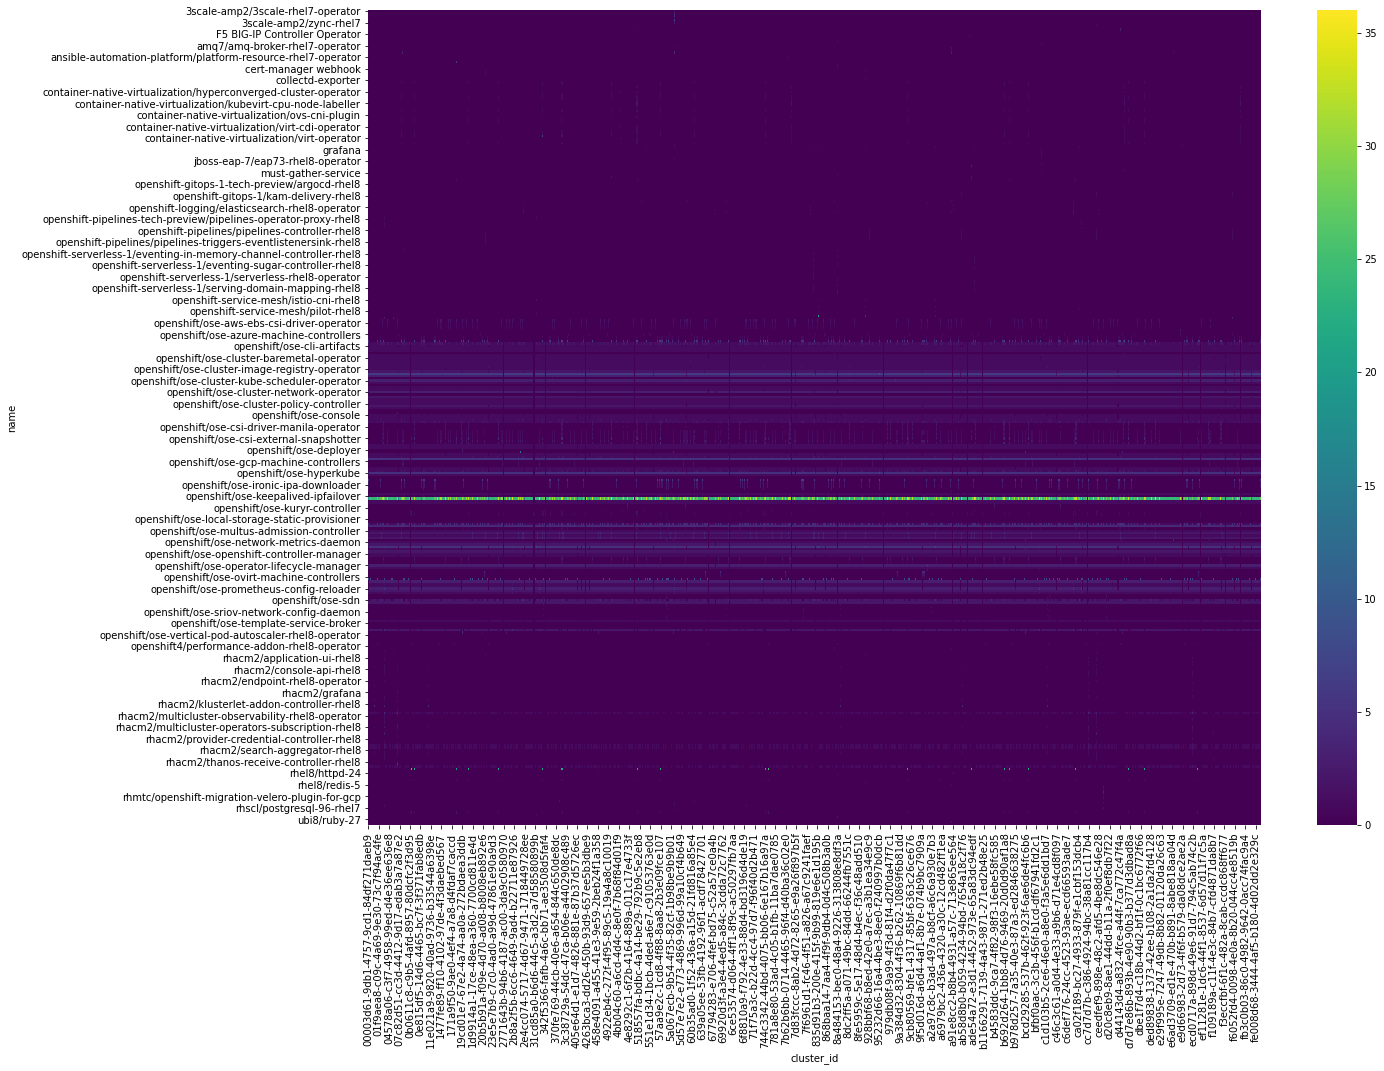

In [22]:
d7 = df_cont["name"]
d8 = df_cont["cluster_id"]

crosstab1 = pd.crosstab(d7, d8)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstab1, cmap="viridis", annot=False)

Here, we do see a dominant product present in the heat map. Now, listing out the most common products name,

In [23]:
s1 = df_cont.groupby("name")["cluster_id"].nunique()
s1 = s1.reset_index().sort_values(by="cluster_id", ascending=False)
s1.head(20)

name  cluster_id
167         openshift/ose-cluster-node-tuning-operator        1848
168  openshift/ose-cluster-openshift-apiserver-oper...        1848
157      openshift/ose-cluster-kube-apiserver-operator        1848
146            openshift/ose-cloud-credential-operator        1848
151              openshift/ose-cluster-config-operator        1848
211                      openshift/ose-kube-rbac-proxy        1848
163             openshift/ose-cluster-machine-approver        1848
147      openshift/ose-cluster-authentication-operator        1847
172             openshift/ose-cluster-storage-operator        1847
152  openshift/ose-cluster-csi-snapshot-controller-...        1847
188              openshift/ose-csi-snapshot-controller        1846
189      openshift/ose-csi-snapshot-validation-webhook        1846
169  openshift/ose-cluster-openshift-controller-man...        1845
153                 openshift/ose-cluster-dns-operator        1845
234                  openshift/ose-openshift-apiserver        1845
178                              openshift/ose-coredns        1845
194                                 openshift/ose-etcd        1845
144                                  openshift/ose-cli        1845
161  openshift/ose-cluster-kube-storage-version-mig...        1843
160      openshift/ose-cluster-kube-scheduler-operator        1843

Now, plotting the top product name with respect to the number of cluster_id it is present in.

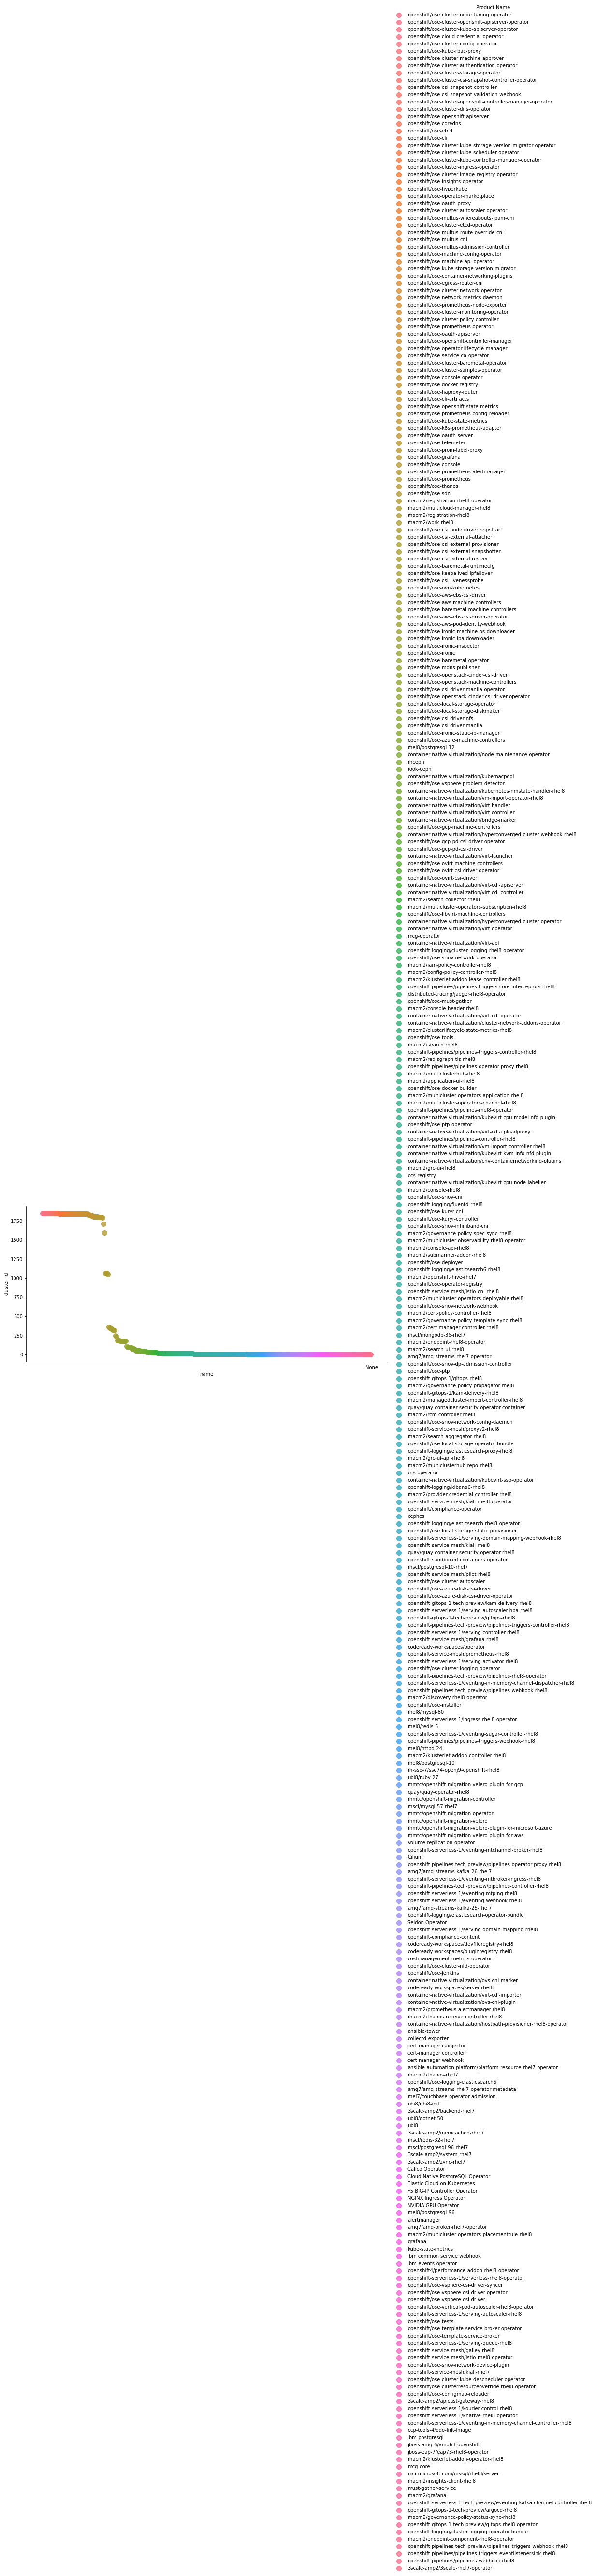

In [24]:
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=s1,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 4,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

The result is preety large, because of huge number of product name. Lets limit the product name to top 20 and plot.

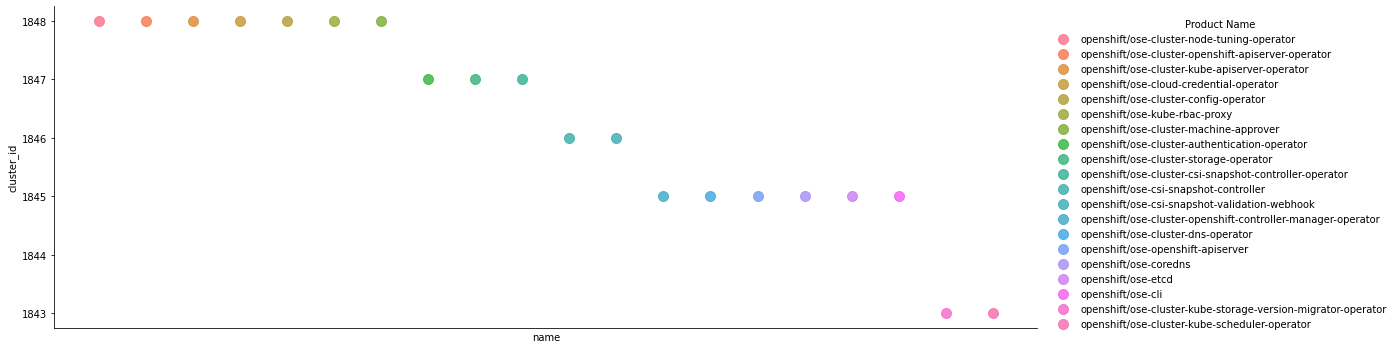

In [25]:
s11 = s1.head(20)
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=s11,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 3.3,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

## Distribution of image_ids in clusters:

In this section, we list out the image_id that are present in different clusters. We do the analysis for both image_layer_dataset and containers dataset.

In [26]:
# List out the image_id with the number of cluster_id for image_layer dataset:
df1 = (
    df_image.groupby(["image_id"])
    .agg({"cluster_id": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["cluster_id"], ascending=False)
)
df1.head(10)

image_id  cluster_id
52   sha256:3574d6c1fcc46e1ebd41b7b887b92035ea18213...        1207
51   sha256:337c22cabe530213b14965f9ea69a92dbeb5104...        1204
198  sha256:c588b4653ef037b1300f9692b986cbeac5dfe5e...        1170
169  sha256:b3177a6ad870f49f3bb6ce9a53344b14a4150c8...         989
178  sha256:b78a94d28cadd60465a722c17a11f3a56ac31aa...         507
40   sha256:29678039a1f6622e9bedbb173a3e16328047fc9...         507
47   sha256:301eb8b5ce7f2ce301acee7839071f7a2aca8d5...         482
241  sha256:f20da357075c74f56a7aa794cad703e13e0ad08...         482
18   sha256:12b8150c9ca3b0e4d0d58ee21bb20c2de9f3d9e...         189
203  sha256:c83ffefa96c0b9590dadfa6fe4732871984397f...         156

In [27]:
df1 = pd.merge(df1, image_id_mapping, how="outer")
df1 = df1.fillna("Not Identified")
df1[["image_id", "name", "summary", "cluster_id"]].head(10)

image_id  \
0  sha256:3574d6c1fcc46e1ebd41b7b887b92035ea18213...   
1  sha256:337c22cabe530213b14965f9ea69a92dbeb5104...   
2  sha256:c588b4653ef037b1300f9692b986cbeac5dfe5e...   
3  sha256:b3177a6ad870f49f3bb6ce9a53344b14a4150c8...   
4  sha256:b78a94d28cadd60465a722c17a11f3a56ac31aa...   
5  sha256:29678039a1f6622e9bedbb173a3e16328047fc9...   
6  sha256:301eb8b5ce7f2ce301acee7839071f7a2aca8d5...   
7  sha256:f20da357075c74f56a7aa794cad703e13e0ad08...   
8  sha256:12b8150c9ca3b0e4d0d58ee21bb20c2de9f3d9e...   
9  sha256:c83ffefa96c0b9590dadfa6fe4732871984397f...   

                          name  \
0            openshift/ose-cli   
1  openshift/ose-cli-artifacts   
2    openshift/ose-oauth-proxy   
3               Not Identified   
4               Not Identified   
5               Not Identified   
6               Not Identified   
7               Not Identified   
8    openshift/ose-oauth-proxy   
9            openshift/ose-cli   

                                             summary  cluster_id  
0  Provides the latest release of Red Hat Univers...        1207  
1  Provides the latest release of Red Hat Univers...        1204  
2  Provides the latest release of Red Hat Univers...        1170  
3                                     Not Identified         989  
4                                     Not Identified         507  
5                                     Not Identified         507  
6                                     Not Identified         482  
7                                     Not Identified         482  
8  Provides the latest release of Red Hat Univers...         189  
9  Provides the latest release of Red Hat Univers...         156

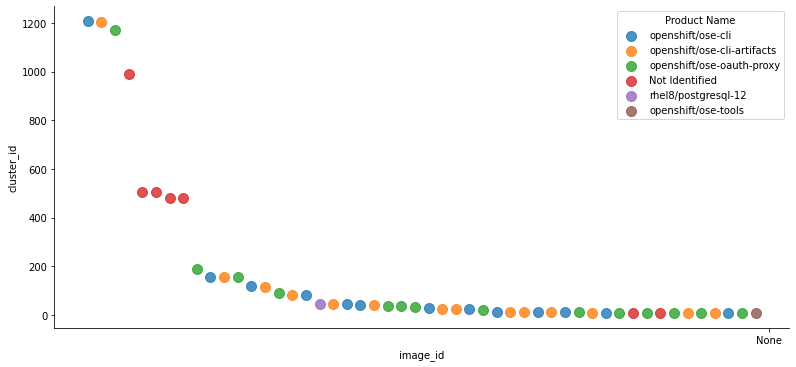

In [28]:
df_head50 = df1.head(50)

g = sns.lmplot(
    x="image_id",
    y="cluster_id",
    data=df_head50,
    fit_reg=False,
    hue="name",
    legend_out=False,
    aspect=10 / 3.3,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

The figure shows us the list of product name as a legend, represented by different color. 

In the next case, we plot the number of cluster_id with respect to image_id along with corresponding product name for the bottom 50 most populated image_ids.

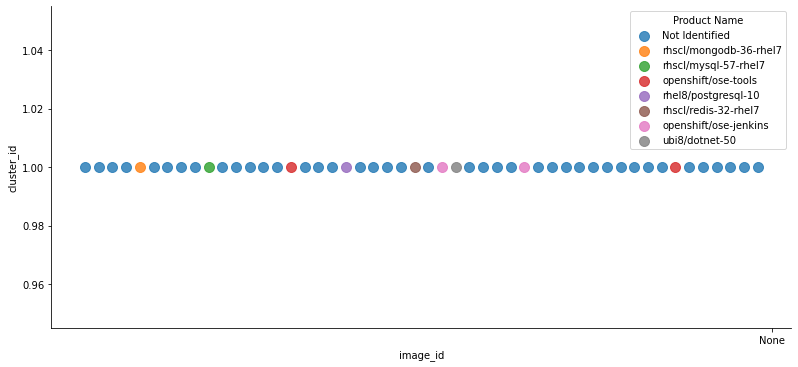

In [29]:
df_tail50 = df1.tail(50)

g = sns.lmplot(
    x="image_id",
    y="cluster_id",
    data=df_tail50,
    fit_reg=False,
    hue="name",
    legend_out=False,
    aspect=10 / 3.3,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

---

Similarly, the list of top 10 images in the container that are running in a cluster.

In [30]:
df2 = (
    df_cont.groupby(["image_id"])
    .agg({"cluster_id": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["cluster_id"], ascending=False)
)
df2.head(10)

image_id  cluster_id
2655  sha256:709dbe2172b81cafe1ac55a01705a88f0865182...        2721
4154  sha256:b96c41f14bf2d701ec369a950dc85b3a1d11fa9...        2551
3886  sha256:ab53dd55e04a29b2f252d0fdc4f7935a464cd8f...        1792
3644  sha256:9f524db33137d2b58ac23de62379d61c507243e...        1790
3291  sha256:8f2498ea99f708695d1795cef47da5f5173b6ab...        1361
1992  sha256:51074a19d1c6cf35a5dd0168abfca8c8685601a...        1340
4781  sha256:d9fdd883c8d147c38146a3c6342a04b7a295adc...        1339
3127  sha256:869e5f8786b9fc5a5bfef090fd6270973b911c4...        1339
1502  sha256:3c17486313a82d91260da08357f5a3139723ad5...        1339
1642  sha256:4241ab0ef919cbfa7a169d4f3b43f4ab1e5e70b...        1339

In [31]:
df2 = pd.merge(df2, cont_imageid_map, how="outer")
df2 = df2.fillna("Not Identified")
df2[["image_id", "name", "summary", "cluster_id"]].head(10)

image_id  \
0  sha256:709dbe2172b81cafe1ac55a01705a88f0865182...   
1  sha256:b96c41f14bf2d701ec369a950dc85b3a1d11fa9...   
2  sha256:ab53dd55e04a29b2f252d0fdc4f7935a464cd8f...   
3  sha256:9f524db33137d2b58ac23de62379d61c507243e...   
4  sha256:8f2498ea99f708695d1795cef47da5f5173b6ab...   
5  sha256:51074a19d1c6cf35a5dd0168abfca8c8685601a...   
6  sha256:d9fdd883c8d147c38146a3c6342a04b7a295adc...   
7  sha256:869e5f8786b9fc5a5bfef090fd6270973b911c4...   
8  sha256:3c17486313a82d91260da08357f5a3139723ad5...   
9  sha256:4241ab0ef919cbfa7a169d4f3b43f4ab1e5e70b...   

                                                name  \
0                                     Not Identified   
1                                     Not Identified   
2                                     Not Identified   
3                                     Not Identified   
4                                 openshift/ose-etcd   
5                              openshift/ose-coredns   
6         openshift/ose-cluster-node-tuning-operator   
7  openshift/ose-cluster-openshift-apiserver-oper...   
8      openshift/ose-cluster-kube-apiserver-operator   
9                 openshift/ose-cluster-dns-operator   

                                             summary  cluster_id  
0                                     Not Identified        2721  
1                                     Not Identified        2551  
2                                     Not Identified        1792  
3                                     Not Identified        1790  
4  Provides the latest release of Red Hat Univers...        1361  
5  Provides the latest release of Red Hat Univers...        1340  
6  Provides the latest release of Red Hat Univers...        1339  
7  Provides the latest release of Red Hat Univers...        1339  
8  Provides the latest release of Red Hat Univers...        1339  
9  Provides the latest release of Red Hat Univers...        1339

Plotting the top 10 image_id with respect to cluster_id for different product name.

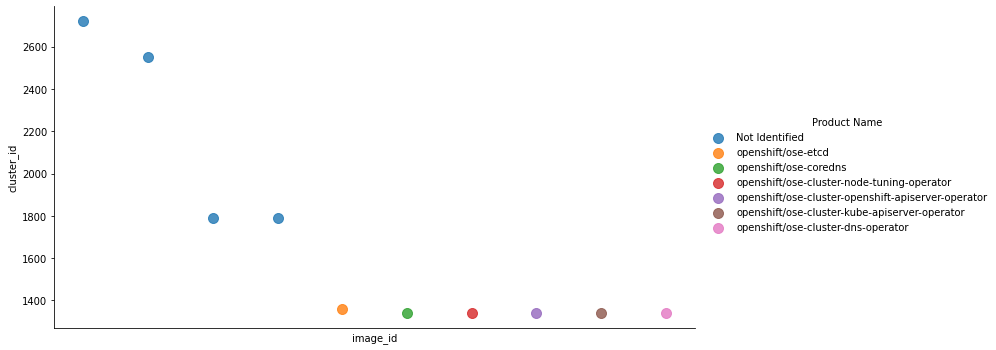

In [32]:
dfc_head50 = df2.head(10)

g = sns.lmplot(
    x="image_id",
    y="cluster_id",
    data=dfc_head50,
    fit_reg=False,
    hue="name",
    legend=True,
    aspect=10 / 4,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

Similarly, plotting the bottom 10 image_ids with respect to cluster_id.

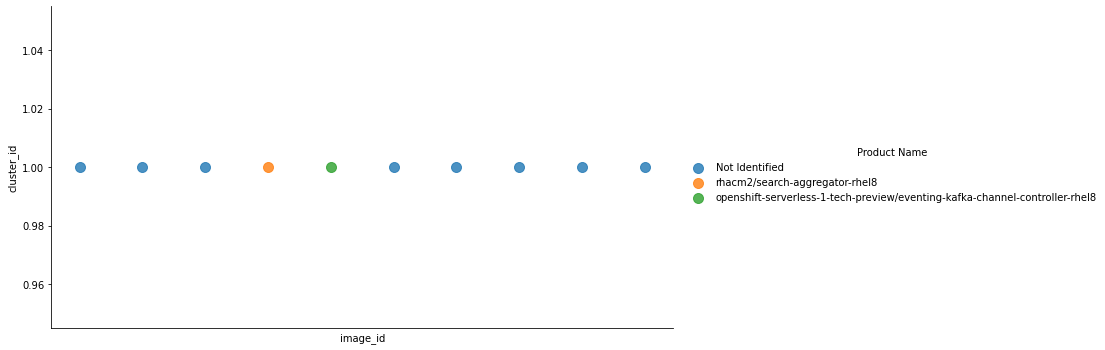

In [33]:
dfc_tail50 = df2.tail(10)

g = sns.lmplot(
    x="image_id",
    y="cluster_id",
    data=dfc_tail50,
    fit_reg=False,
    hue="name",
    legend=True,
    aspect=10 / 4,
    scatter_kws={"s": 100},
)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

---

## **What are the commands that occur together?**

To address this query, we used the groupby method to form a dataframe which would give us the list of commands and the corresponding argument that corresponds to the particular command in the dataset. 

In [34]:
# For the image_layer dataset : df_image
df3 = df_image[["first_command", "first_arg"]]
df3 = df3.groupby(["first_command", "first_arg"]).size()
df3 = df3.to_frame()
df3.rename(columns={0: "frequency"}, inplace=True)
df3 = df3.sort_values(by=["frequency"], ascending=False)
df3.head(50)

frequency
first_command first_arg              
icTsn2s_EIax  2v1NneeWoS_9      27234
lwp1IAZLTWcp  icTsn2s_EIax        649
icTsn2s_EIax  icTsn2s_EIax         26
eXOGhaZW_msl  icTsn2s_EIax         25
              15Z3GIaH57Mr         18
              KVNJDjO6_knB         13
b51B0EZ1bw3c  icTsn2s_EIax         12
lwp1IAZLTWcp  h45OnGCW1OSR         11
Poq-znsLooiE  47DEQpj8HBSa         10
b51B0EZ1bw3c  zO0oxtw_mcI5          9
N9KxLV2avCo2  icTsn2s_EIax          6
R2zXWhUnSgIM  icTsn2s_EIax          6
c8xKHtkOWaJH  icTsn2s_EIax          5
Ad4Rg1Av8Y0X  icTsn2s_EIax          4
3C4BfYP4q5EN  icTsn2s_EIax          4
nxKqHhNS6WsO  icTsn2s_EIax          3
buSkac1OkQU4  icTsn2s_EIax          3
2B5peo-_Thrw  icTsn2s_EIax          2

Lets try to visualize it with the help of cross tabulation table. 

<AxesSubplot:xlabel='first_arg', ylabel='first_command'>

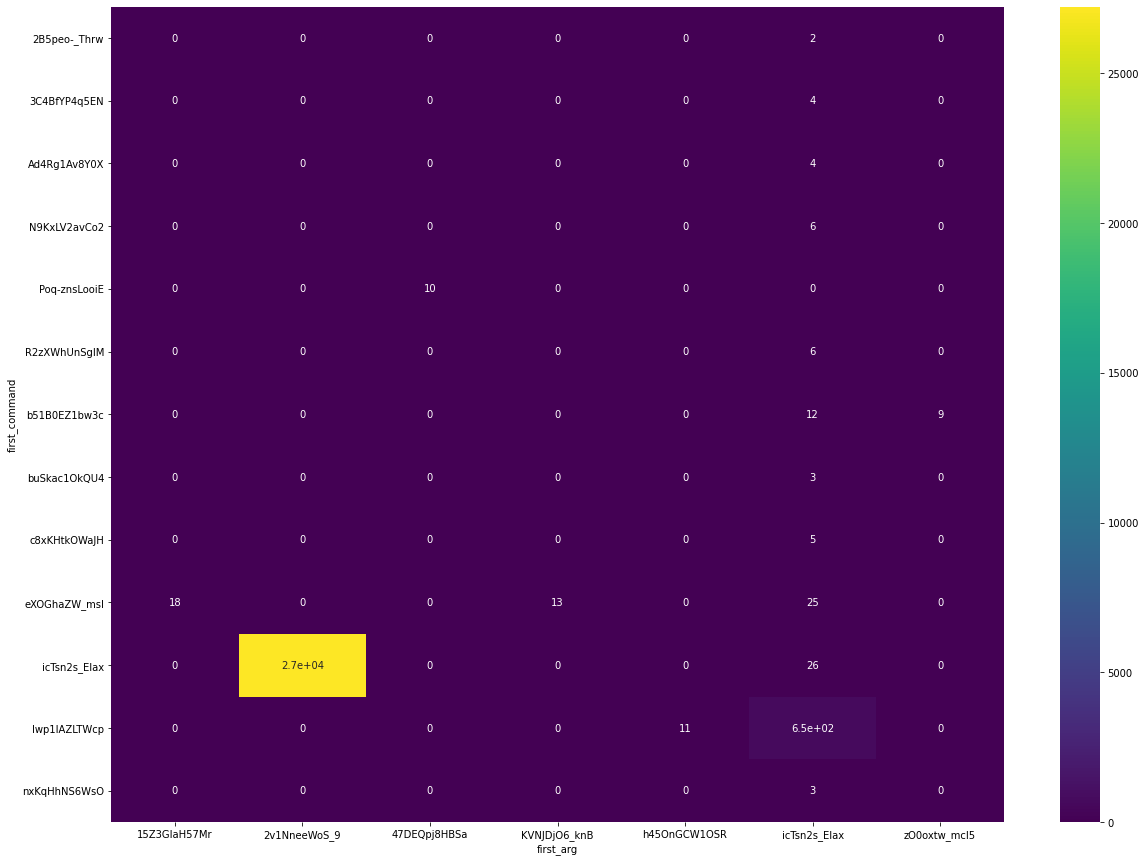

In [35]:
c1 = df_image["first_command"]
c2 = df_image["first_arg"]

crosstabc = pd.crosstab(c1, c2)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstabc, cmap="viridis", annot=True)

The dataframe above represents the list of first commands and their corresponding arguments and their frequency (number of times they appeared in the dataset). Most of the _first commands_ have a corresponding single _first_arg_. But there are some _first_commands_ in the dataset which corresponds to multiple _first_arg_. E.g. for first command, **eXOGhaZW_msl**, we have **icTsn2s_EIax**, **15Z3GIaH57Mr**, and **KVNJDjO6_knB** as corresponding first arguments. The frequencies of each are shown on the column next to it. The annotation in the cross tabulation table gives a better pictorial view about the distribution of different commands and argument.

We also explored the same query in the container dataset: _df_cont_

In [36]:
# For the containers dataset : df_cont
df4 = df_cont[["first_command", "first_arg"]]
df4 = df4.groupby(["first_command", "first_arg"]).size()
df4 = df4.to_frame()
df4.rename(columns={0: "frequency"}, inplace=True)
df4 = df4.sort_values(by=["frequency"], ascending=False)
df4.head(10)

frequency
first_command first_arg              
N9KxLV2avCo2  k19oMZ1PIn4C      16108
              930btY2ohuPL      11509
VvlllczXFX2z  47DEQpj8HBSa       5779
930btY2ohuPL  CSx56PgOVZ5A       5764
VvlllczXFX2z  5gS4z5mOnDuY       5730
NJuOSOguFZRT  nw1jEXz0CN6o       5610
b51B0EZ1bw3c  ua-xlwwsvdYd       2995
n9CdwzVF-cwZ  RNOaw_AuQeIY       2939
RxKEaTc90uWM  r7zEsGNvlNrk       2925
XqE_QmN1P920  r7zEsGNvlNrk       2924

<AxesSubplot:xlabel='first_arg', ylabel='first_command'>

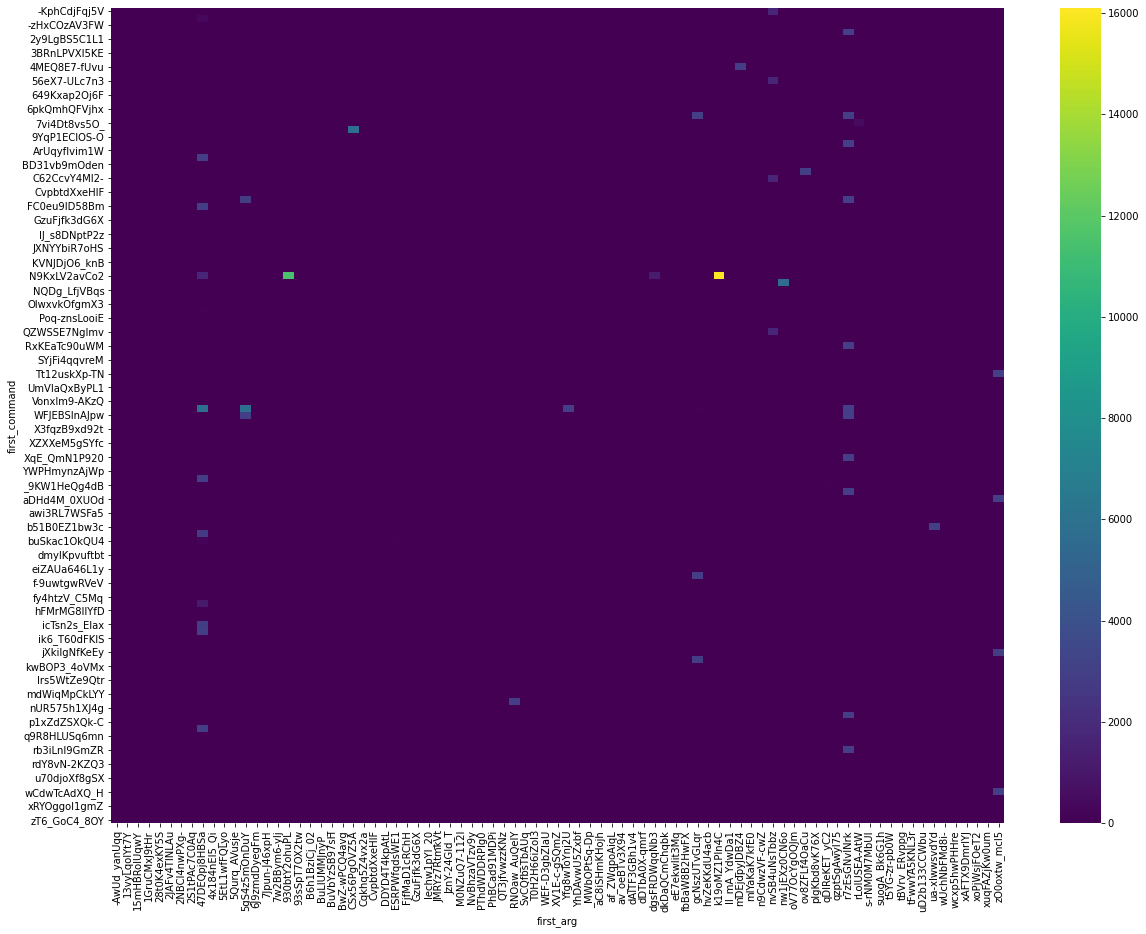

In [37]:
c3 = df_cont["first_command"]
c4 = df_cont["first_arg"]

crosstabc1 = pd.crosstab(c3, c4)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstabc1, cmap="viridis", annot=False)

The _first command_ and _first argument_ information are unclear in the dataset we are working on. From the dataset, we can only have an information about the proportion of different commands and arguments in the dataset involved. The cross tabulation does highlight some highly correlated first_command and argument.

---

## **How many PODs have same image deployed?**

A POD is a group of one or more containers, with shared storage/network, and a specification for how to run the containers. The above question can be addressed through the shape feature of the dataset. If two or more PODs used the same set of containers and same command, they will fall into same shape. Hence, in this dataset, the "shape" will be defining the PODs.

In [38]:
cont_image2 = (
    df_cont.groupby(["image_id"])
    .agg({"shape": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["shape"], ascending=False)
)
cont_image2.head(10)

image_id  shape
1408  sha256:3869910c1e208b125bdecd4ac2d8b2cae42efe2...    105
5466  sha256:ff39116b450fb9f860bf52e907e715e77562a49...     63
4327  sha256:c23edb07dfa50c1923352f67999d36fde3daa16...     49
3679  sha256:a144eeb9090759cb402d2230b959687065fe703...     49
1802  sha256:48b386afbb3a77e5a5aae7c7656e3d0cef72260...     48
5099  sha256:eb291bbd5ebf972b603be9a032e23ced2c4fbff...     44
3478  sha256:970054483a8682d9fafced4c88213338acefb90...     43
5285  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...     39
2452  sha256:673f547354767571f3ab559af96f0eacd680a58...     37
4292  sha256:c0fff01d3cb808c169ce45a05623931363c136a...     36

The above table gives us the information about the number of PODs which have the same image deployed. We can merge the product name and summary with the above dataset to list out the product name corresponding to the image_id.

In [39]:
cont_image2 = pd.merge(cont_image2, cont_imageid_map, how="outer")
cont_image2.fillna("Not Identified")
cont_image2.head(10)

image_id  shape  \
0  sha256:3869910c1e208b125bdecd4ac2d8b2cae42efe2...    105   
1  sha256:ff39116b450fb9f860bf52e907e715e77562a49...     63   
2  sha256:c23edb07dfa50c1923352f67999d36fde3daa16...     49   
3  sha256:a144eeb9090759cb402d2230b959687065fe703...     49   
4  sha256:48b386afbb3a77e5a5aae7c7656e3d0cef72260...     48   
5  sha256:eb291bbd5ebf972b603be9a032e23ced2c4fbff...     44   
6  sha256:970054483a8682d9fafced4c88213338acefb90...     43   
7  sha256:f46f210d6023bec16e68340b484a8881ce46d5e...     39   
8  sha256:673f547354767571f3ab559af96f0eacd680a58...     37   
9  sha256:c0fff01d3cb808c169ce45a05623931363c136a...     36   

                            name summary  
0                            NaN     NaN  
1  openshift/ose-kube-rbac-proxy          
2  openshift/ose-kube-rbac-proxy          
3  openshift/ose-kube-rbac-proxy          
4  openshift/ose-kube-rbac-proxy          
5  openshift/ose-kube-rbac-proxy          
6  openshift/ose-kube-rbac-proxy          
7  openshift/ose-kube-rbac-proxy          
8  openshift/ose-kube-rbac-proxy          
9  openshift/ose-kube-rbac-proxy

The nan values corresponds to the ids, we cound not map using the described technique. In the dataframe, NaN is replaced by string, "Not Identified". 

We plot the top 100 image_id with respect to shape and product name.

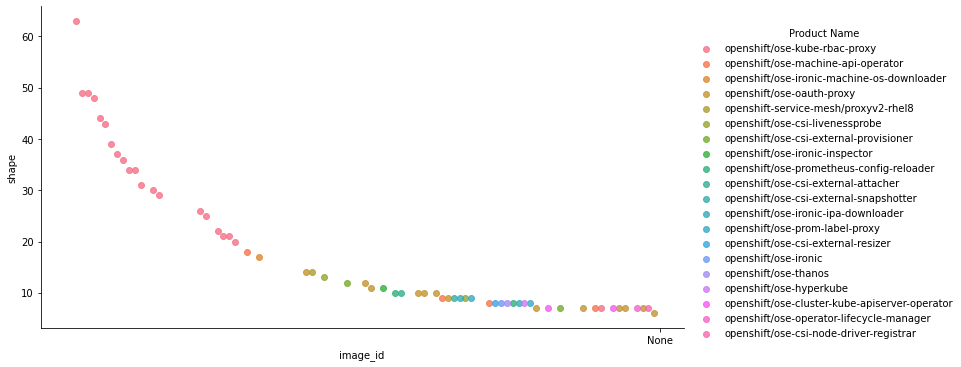

In [40]:
df_cont_imagehead100 = cont_image2.head(100)

g = sns.lmplot(
    x="image_id",
    y="shape",
    data=df_cont_imagehead100,
    fit_reg=False,
    hue="name",
    legend=True,
    aspect=10 / 4,
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

We now plot the bottom 100 image_id with respect to shape and product name.

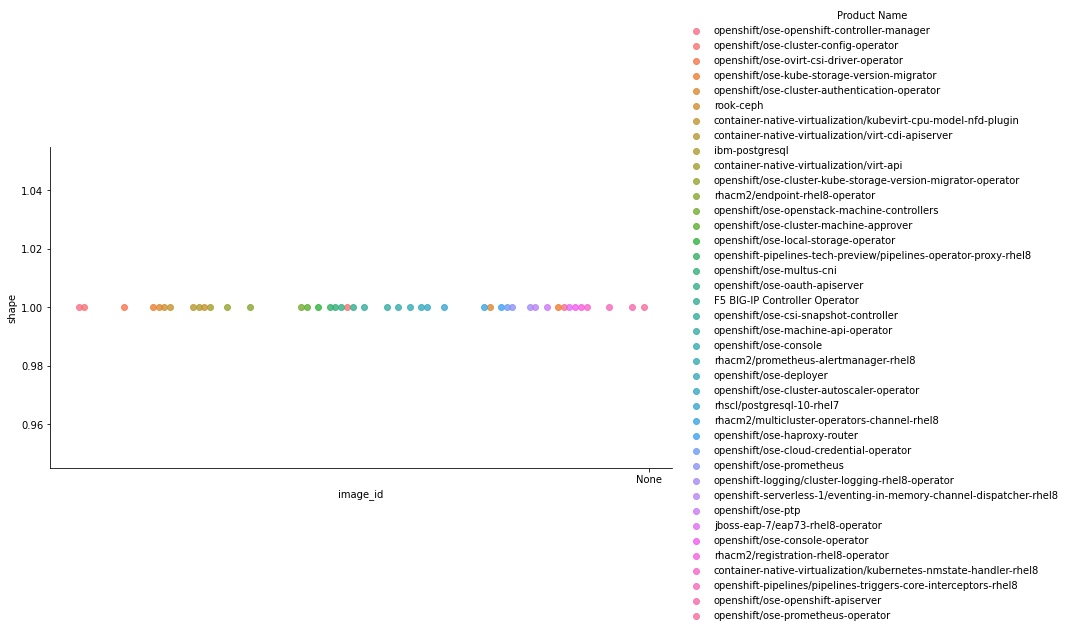

In [41]:
df_cont_imagetail100 = cont_image2.tail(100)

g = sns.lmplot(
    x="image_id",
    y="shape",
    data=df_cont_imagetail100,
    fit_reg=False,
    hue="name",
    legend=True,
    aspect=10 / 4,
)
# plt.figsize(16,10)
g._legend.set_title("Product Name")
plt.xticks("None")
plt.show()

---

## **Are there any images that occur in only one cluster?**

The approach is similar to finding the number of images that occurs in a cluster. Once, we have the set of images along with the number of cluster ids. We can get the information about the image_id, which occur in only one cluster.

From the image layer dataset, the results are below. 

In [42]:
image2 = (
    image_layers_df.groupby(["image_id"])
    .agg({"cluster_id": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["cluster_id"], ascending=True)
)
image2.head(10)

image_id  cluster_id
0    sha256:00c7b9643efc790dd9dd9ee37a15cc6c99d6c6d...           1
145  sha256:a432b1298cbf87f96935e39c9846d8846284402...           1
146  sha256:a49b7d567962fae7cb0749a11f81dc8a0c9470a...           1
148  sha256:a5995f6e041a400e0aa0aa81153a6a90c2b4a51...           1
149  sha256:a67e88f3da133e68ccf5c121d003548e80344fe...           1
151  sha256:a8dcb1924ec3ef36c1dcbec5f06a8decd7b1b67...           1
152  sha256:a9062538fdca6913d803bb4a9500f4fd303d022...           1
153  sha256:a9bdf52384a222635efc0284db47d12fbde8c3d...           1
154  sha256:aaea76ff622d2f8bcb32e538e7b3cd0ef6d2919...           1
155  sha256:ab3d23ae5f2c70aef880ded1adddfe3f97ed5b1...           1

Now, linking the corresponding image_id with the product name. We have,

In [43]:
image2 = pd.merge(image2, image_id_mapping, how="outer")
image2.head(10)

image_id  cluster_id  \
0  sha256:00c7b9643efc790dd9dd9ee37a15cc6c99d6c6d...           1   
1  sha256:a432b1298cbf87f96935e39c9846d8846284402...           1   
2  sha256:a49b7d567962fae7cb0749a11f81dc8a0c9470a...           1   
3  sha256:a5995f6e041a400e0aa0aa81153a6a90c2b4a51...           1   
4  sha256:a67e88f3da133e68ccf5c121d003548e80344fe...           1   
5  sha256:a8dcb1924ec3ef36c1dcbec5f06a8decd7b1b67...           1   
6  sha256:a9062538fdca6913d803bb4a9500f4fd303d022...           1   
7  sha256:a9bdf52384a222635efc0284db47d12fbde8c3d...           1   
8  sha256:aaea76ff622d2f8bcb32e538e7b3cd0ef6d2919...           1   
9  sha256:ab3d23ae5f2c70aef880ded1adddfe3f97ed5b1...           1   

                   name                                            summary  
0                   NaN                                                NaN  
1                   NaN                                                NaN  
2   rhel8/postgresql-10  PostgreSQL is an advanced Object-Relational da...  
3                   NaN                                                NaN  
4                   NaN                                                NaN  
5                   NaN                                                NaN  
6                   NaN                                                NaN  
7  rhscl/redis-32-rhel7  Redis in-memory data structure store, used as ...  
8                   NaN                                                NaN  
9   openshift/ose-tests  Provides the latest release of Red Hat Univers...

Following the similar procedure for the container dataset.

In [44]:
cont_image3 = (
    containers_df.groupby(["image_id"])
    .agg({"cluster_id": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["cluster_id"], ascending=True)
)
cont_image3.head(10)

image_id  cluster_id
0     sha256:000a751718a0a952c37b005f857456e4246cbf9...           1
2757  sha256:74e45b4b999cdb47ba223ed9586e6061dbb70f3...           1
2758  sha256:74f264c6eb6f4794a1099958cafd8a7a9ff5fa5...           1
2759  sha256:74fc7f0df654594f396d703f57b8014348c1e95...           1
5166  sha256:edee8d1f12c76a97925b91e088c2fe39235095c...           1
2766  sha256:75183bfd70aa8d9ca1a480e4f316892a66e7fa7...           1
2768  sha256:752afa082575cb19d7a0b7c797a78c35aa1dda8...           1
2770  sha256:7541e5cbada5e8ccf53655bd7ad5c64883d2ad2...           1
2771  sha256:755269bb86bad3592a790586ed8f8a3288874ba...           1
2775  sha256:7580aa2dcdf036447b209381fc0128f04d189c5...           1

In [45]:
cont_image3 = pd.merge(cont_image3, cont_imageid_map, how="outer")
cont_image3.head(10)

image_id  cluster_id  \
0  sha256:000a751718a0a952c37b005f857456e4246cbf9...           1   
1  sha256:74e45b4b999cdb47ba223ed9586e6061dbb70f3...           1   
2  sha256:74f264c6eb6f4794a1099958cafd8a7a9ff5fa5...           1   
3  sha256:74fc7f0df654594f396d703f57b8014348c1e95...           1   
4  sha256:edee8d1f12c76a97925b91e088c2fe39235095c...           1   
5  sha256:75183bfd70aa8d9ca1a480e4f316892a66e7fa7...           1   
6  sha256:752afa082575cb19d7a0b7c797a78c35aa1dda8...           1   
7  sha256:7541e5cbada5e8ccf53655bd7ad5c64883d2ad2...           1   
8  sha256:755269bb86bad3592a790586ed8f8a3288874ba...           1   
9  sha256:7580aa2dcdf036447b209381fc0128f04d189c5...           1   

                                                name  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                openshift/ose-csi-external-attacher   
5                    openshift/ose-operator-registry   
6  container-native-virtualization/virt-cdi-contr...   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                                             summary  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  Provides the latest release of Red Hat Univers...  
5  Operator Registry runs in a Kubernetes or Open...  
6           Controller for the data fetching service  
7                                                NaN  
8                                                NaN  
9                                                NaN

---

## Is customer cluster is empty, testing or full? 

In [46]:
cont_image4 = (
    df_cont.groupby(["cluster_id"])
    .agg({"shape_instances": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["shape_instances"], ascending=True)
)
cont_image4.head(10)

cluster_id  shape_instances
2456  d46df89c-cb5c-467c-bde6-109d2d440031                1
2216  c04ca332-ac85-4fd6-837c-c24f6c09f1b4                1
1102  618a5444-bb49-45eb-ac27-1949e175c4a1                1
2548  dcb7efad-feb6-45be-9a7d-ea608f26278f                1
0     00003d61-9db1-4757-9cd1-84df271daeb9                2
1793  9c8535e9-a21c-4585-8102-07e5f33c8c92                2
1796  9cb80569-bfe1-4317-85bf-6363c26ce676                2
1797  9ceb42ff-772d-4cdf-b9eb-c6b3b0a1e628                2
792   474f7a6a-cfbe-4ac2-9644-7c4013c34367                2
1798  9d3bfcd9-4914-409c-8ec5-13ba43c4a7e9                2

To address this query, we try to look for those cluster_id/image_id and the minimum number of shape_instances, which defines the number of POD of certain shape. We observe that no cluster is empty. Each cluster is running atleast one POD, defined by the shape instances.

## How many users are deploying HA configurations?

HA (High availability) configurations are the POD with 3 or more replicas. The query refers to finding the cluster_id with 3 or more shape instances. Shape instances is defined as the number of PODs of particular shape. Hence, if we generate a dataframe which list out the cluster_id and corresponding shape instances. We will have the information about the number of users deploying HA configurations. 

In [47]:
cont_image5 = df_cont[["cluster_id", "shape_instances"]]

Cluster_id containing 3 or more shape instances:

In [48]:
cont_image5 = cont_image5[(cont_image5["shape_instances"] >= 3)]
cont_image5 = cont_image5.sort_values(by="shape_instances", ascending=False)
cont_image5.head(10)

cluster_id  shape_instances
450364  8505f31a-ba37-4e67-9441-0863b38b23c1             1500
453448  70795f27-2ccc-4719-ae89-2ad33f2bce93              683
452872  645eecc4-917b-43e1-a2d0-eba9781d406c              500
452877  ebf54a64-9c86-4281-850d-f8764aece456              500
450365  9894d014-e1cd-4e39-b114-15490988b9f0              500
452871  645eecc4-917b-43e1-a2d0-eba9781d406c              500
452878  ebf54a64-9c86-4281-850d-f8764aece456              500
452876  ebf54a64-9c86-4281-850d-f8764aece456              500
452874  645eecc4-917b-43e1-a2d0-eba9781d406c              500
452873  645eecc4-917b-43e1-a2d0-eba9781d406c              500

Hence, the number of cluster_id deploying HA configurations are,

In [49]:
cont_image5.cluster_id.nunique()

1767

Total number of unique cluster_id: 

In [50]:
df_cont.cluster_id.nunique()

2927

Hence, out of 2927 cluster_id, 1767, i.e, ~60% of the total cluster id have HA configuration.

## What are the most common base images - RHEL or UBI or others?

The base images are those images for which the layer_image_level = 0. Hence, If we can make a list of base images and count them according to their number of occurance. We can get the most common base images. 

Lets start with filtering out the dataset by including only the set for which the layer_image_level = 0.

In [51]:
df_image3 = df_image[(df_image["layer_image_level"] == 0)]
df_base = df_image3["layer_image_id"].value_counts()
df_base.head(10)

sha256:9ebb302e1fb002fb643091710dac46f8258781d5b8ee8c9a5a7c06361af23bd0    5919
sha256:6b536614e8f89a67294fb2b5a743b44675697c47e22b116d03249fbf1f0da8c0    2030
sha256:13897c84ca5715a68feafcce9acf779f35806f42d1fcd37e8a2a5706c075252d     219
sha256:cf0a16f210ccd6c827ab3f2015649674a9ad2da7ab41031b3259cc6e8ec3c137     114
sha256:99175d5a93b0ce65220c214840978f43fe7029d73a6554f40dea850ca456bb79      90
sha256:4b21dcdd136d133a4df0840e656af2f488c226dd384a98b89ced79064a4081b4      68
sha256:12759cfb2d9fd40b1f65b14a9194473f85b9c54eb6d07143f0e0e2124d918143      41
sha256:174e47727a3560ec5d85f4cdac2fd06193ccf4d17b3946777ae8ff90ecdbf83a      29
sha256:5d7c51f107643d6a4f86a141842ee1babfcd457e749d97aa4b7e0fd347d8bf5f      11
sha256:b4a6e23922ddc3d105fee9afff80151a13fe058143351a8e9294286575f2f37e       9
Name: layer_image_id, dtype: int64

The above list gives us the list of base layer_image_id with it number of occurance. The most common base image ID is given by **"sha256:9ebb302e1fb002fb643091710dac46f8258781d5b8ee8c9a5a7c06361af23bd0"**. The method described in [issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/14) did not worked well for extracting product name for the layer image ids. For that purpose, we may need to figure out some other method.   

# Conclusion

The notebook provides some information about the EDA of the insight operator workload dataset. We do answered some questions regarding different proportion of features in the data, in relation to another. For example, we could find the number of image_id present in maxmimum cluster id. We could then link that sha of the image id with that of its name using [Pyxis](https://pyxis.engineering.redhat.com/v1/ui/#/).


In our next approach, we will track the CPU-usage information based on a particular cluster id using the [link](https://telemeter-lts.datahub.redhat.com/graph?g0.range_input=1h&g0.moment_input=2021-06-25%2005%3A40%3A08&g0.max_source_resolution=0s&g0.expr=&g0.tab=1), and integrate them with the dataframe we have, to discover most insights into the workloads.

---